# Prediction: Logistic Regression

> **Warning!** Please run `01_cleaning.ipynb` first if you haven't already

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from functions.constants import BM_NAME, STARTDATE, ENDDATE, N_THRESHOLD_BPS,DATA_DIR
from functions.helper_fns import *
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns

In [4]:
active_returns_path = DATA_DIR + BM_NAME + "_active_returns.csv"
active_returns = pd.read_csv(active_returns_path, index_col=0, parse_dates=True)
print("Loaded active returns from", active_returns_path)
active_returns_thresholded_path = DATA_DIR + BM_NAME + "_active_returns_thresholded_" + str(N_THRESHOLD_BPS) + "bps.csv"
active_returns_thresholded = pd.read_csv(active_returns_thresholded_path, index_col=0, parse_dates=True)
print("Loaded active returns thresholded from", active_returns_thresholded_path)

Loaded active returns from ./../data/SP500_active_returns.csv
Loaded active returns thresholded from ./../data/SP500_active_returns_thresholded_100bps.csv


In [5]:
TEST_TICKER = "GS UN" # Goldman Sachs--also try "AAPL UW" and "JPM UN"
test_ticker_df = active_returns[active_returns["Ticker"] == TEST_TICKER]
test_ticker_df.reset_index(drop=True, inplace=True)
test_ticker_df

,Ticker,Date,active_returns_1b,active_returns_1w,active_returns_1m,active_returns_1q,active_returns_1y
0,GS UN,2021-09-01,0.000051,-0.004898,-0.004898,-0.004898,-0.004898
1,GS UN,2021-02-03,0.004497,0.034515,0.034515,0.034515,0.034515
2,GS UN,2018-03-29,-0.003785,-0.001863,-0.001863,-0.001863,-0.001863
3,GS UN,2022-07-26,-0.005642,0.005545,0.005545,0.005545,0.005545
4,GS UN,2020-08-13,-0.015584,0.013023,0.013023,0.013023,0.013023
...,...,...,...,...,...,...,...
2447,GS UN,2015-09-18,-0.013388,-0.021831,-0.021831,-0.021831,-0.021831
2448,GS UN,2016-12-19,-0.001264,0.005543,0.005543,0.005543,0.005543
2449,GS UN,2018-08-06,0.004322,-0.029694,-0.029694,-0.029694,-0.029694
2450,GS UN,2022-03-08,0.005618,0.010669,0.010669,0.010669,0.010669


In [6]:
NUM_FEATURES = 12
PREDICTION_PERIOD = "1w"
MODEL_USING_DF = active_returns
# MODEL_USING_DF = test_ticker_df #turn this on to run for one company
df = featurize_time_series(MODEL_USING_DF, PREDICTION_PERIOD, NUM_FEATURES,set_threshold_for_target_var_bps=N_THRESHOLD_BPS)
target_var = "ar_" + PREDICTION_PERIOD + "_t"
X = df.drop(columns=[target_var, "Date", "Ticker"])
y = df[[target_var]]
print("X shape:", X.shape)
print(X.head())
print("y shape:", y.shape)
print(y.head())
X = X.to_numpy()
y = y.to_numpy()

X shape: (249991, 12)
    ar_1w_t_minus_1  ar_1w_t_minus_2  ar_1w_t_minus_3  ar_1w_t_minus_4  \
12         0.008647        -0.008387         0.008395         0.030798   
13        -0.020086         0.008647        -0.008387         0.008395   
14         0.022483        -0.020086         0.008647        -0.008387   
15         0.017339         0.022483        -0.020086         0.008647   
16         0.005448         0.017339         0.022483        -0.020086   

    ar_1w_t_minus_5  ar_1w_t_minus_6  ar_1w_t_minus_7  ar_1w_t_minus_8  \
12         0.006078        -0.007792         0.012361         0.018158   
13         0.030798         0.006078        -0.007792         0.012361   
14         0.008395         0.030798         0.006078        -0.007792   
15        -0.008387         0.008395         0.030798         0.006078   
16         0.008647        -0.008387         0.008395         0.030798   

    ar_1w_t_minus_9  ar_1w_t_minus_10  ar_1w_t_minus_11  ar_1w_t_minus_12  
12        -0

In [7]:
TEST_FRACTION = 0.2
EVAL_FRACTION = 0.2
X_train_and_eval, X_test, y_train_and_eval, y_test = train_test_split(X, y, test_size=TEST_FRACTION, shuffle=False)
X_train, X_eval, y_train, y_eval = train_test_split(X_train_and_eval, y_train_and_eval, test_size=EVAL_FRACTION/(1-TEST_FRACTION), shuffle=False)
print("X_train shape:", X_train.shape)
print("X_eval shape:", X_eval.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_eval shape:", y_eval.shape)
print("y_test shape:", y_test.shape)

X_train shape: (149994, 12)
X_eval shape: (49998, 12)
X_test shape: (49999, 12)
y_train shape: (149994, 1)
y_eval shape: (49998, 1)
y_test shape: (49999, 1)


## Train a simple Logistic Regression classifier

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [9]:
#model = LogisticRegression(class_weight="balanced")
# use random forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_eval)
y_pred_proba = model.predict_proba(X_eval)
print("y_pred shape:", y_pred.shape)
print("y_pred_proba shape:", y_pred_proba.shape)


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


y_pred shape: (49998,)
y_pred_proba shape: (49998, 2)


===TRAINING SET===
Accuracy: 0.6071576196381189
Precision: 0.4232509900056572
Recall: 0.3425932992444478
F1: 0.37867476485722723
ROC AUC: 0.566129961861932
===EVALUATION SET===
Accuracy: 0.5925437017480699
Precision: 0.4145322189269345
Recall: 0.3448082529715183
F1: 0.37646914789422137
ROC AUC: 0.5576344013101202


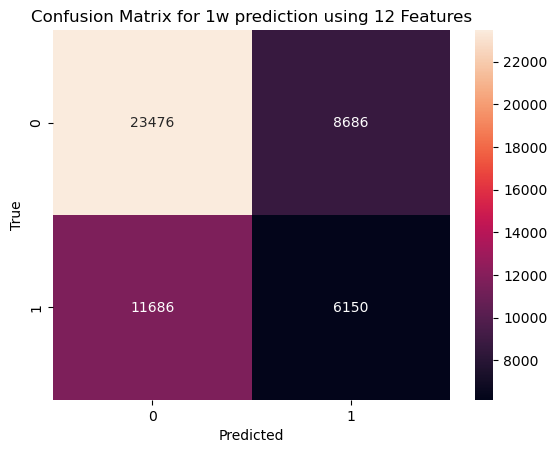

In [13]:
y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)
print("===TRAINING SET===")
evaluate_model_performance(y_train, y_train_pred, y_train_pred_proba,PREDICTION_PERIOD,NUM_FEATURES,plot_confusion_matrix=False)
print("===EVALUATION SET===")
evaluate_model_performance(y_eval, y_pred, y_pred_proba,PREDICTION_PERIOD,NUM_FEATURES)